**Description**
- Swahili is spoken by 100-150 million people across East Africa. In Tanzania, it is one of two national languages (the other is English) and it is the official language of instruction in all schools. News in Swahili is an important part of the media sphere in Tanzania.

- News contributes to education, technology, and the economic growth of a country, and news in local languages plays an important cultural role in many Africa countries. In the modern age, African languages in news and other spheres are at risk of being lost as English becomes the dominant language in online spaces.

**Objective**
- To develop a multi-class classification model to classify news content according to their specific categories specified.
**Application**
- The model can be used by Swahili online news platforms to automatically group news according to their categories and help readers find the specific news they want to read.
-  In addition, the model will contribute to a body of work ensuring that Swahili is represented in apps and other online products in the future.

In [21]:
#Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#export
import os
import time
import re
from tqdm import tqdm

#libraries for feature engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

##Libraries for machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


##Libraries for model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

#libraries for data preprocessing
from nltk import word_tokenize
from bs4 import BeautifulSoup
from io import StringIO
import re

#libraries for saving the model
import joblib

In [20]:
from google.colab import drive

drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgfwXnqIrIuG32ZUFI0xFNRn0kQZv4lyJeJ4nEM--1PErJ0HSh4-5M
Mounted at /content/gdrive


In [22]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/Zindi/data")

**Data Preparation**

In [23]:
# Load data
train=pd.read_csv("Train.csv")
test=pd.read_csv("Test.csv")

In [24]:
#Overview of the data
train.head()

,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [25]:
test.head()

,swahili_id,content
0,001dd47ac202d9db6624a5ff734a5e7dddafeaf2,"MKUU wa Wilaya ya Bahi, Mkoani Dodoma, Mwanah..."
1,0043d97f7690e9bc02f0ed8bb2b260d1d44bad92,"MWISHONI mwa wiki hii, Timu ya Soka ya Taifa,..."
2,00579c2307b5c11003d21c40c3ecff5e922c3fd8,THAMANI ya mauzo ya bidhaa za Afrika Masharik...
3,00868eeee349e286303706ef0ffd851f39708d37,MENEJA Mawasiliano na Utetezi wa asasi ya AGP...
4,00a5cb12d3058dcf2e42f277eee599992db32412,"WAZIRI wa Kilimo, Japhet Hasunga amesema seri..."


In [26]:
#get summary of the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5151 entries, 0 to 5150
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5151 non-null   object
 1   content   5151 non-null   object
 2   category  5151 non-null   object
dtypes: object(3)
memory usage: 120.9+ KB


In [27]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   swahili_id  1288 non-null   object
 1   content     1288 non-null   object
dtypes: object(2)
memory usage: 20.2+ KB


In [28]:
#To find if there are any missing values
print(train.isna().sum())

print("########TEST########")

print(test.isna().sum())


id          0
content     0
category    0
dtype: int64
########TEST########
swahili_id    0
content       0
dtype: int64


- There are no missing values

In [29]:
test.columns

Index(['swahili_id', 'content'], dtype='object')

In [30]:
train['category_code'] = train['category'].factorize()[0]

In [32]:
category_id_df = train[['category', 'category_code']].drop_duplicates().sort_values('category_code')
#convert to a dictionary
category_to_id = dict(category_id_df.values)
#Create a dictionary of category and category_code
id_to_category = dict(category_id_df[['category_code', 'category']].values)

In [33]:
train.head()

,id,content,category,category_code
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa,0
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara,1
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa,0
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo,2
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa,0


In [34]:
train['category'].value_counts()

Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: category, dtype: int64

There are 5 categories of news
- Kitaifa(2000) category has the highest news content followed by michezo(1720).
- Burudani has the lowest content (17)

In [35]:
train['category_code'].value_counts()

0    2000
2    1720
1    1360
3      54
4      17
Name: category_code, dtype: int64

**Number of articles in each category**

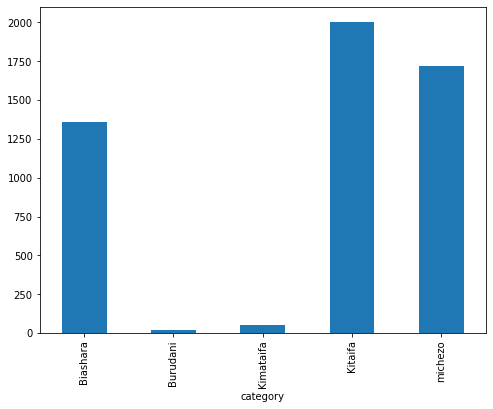

In [36]:
#Plot the classes
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train.groupby('category').content.count().plot.bar()
plt.show()

In [37]:
# import seaborn as sns
# sns.set_style("whitegrid")
# import altair as alt

# # Code for hiding seaborn warnings
# import warnings
# warnings.filterwarnings("ignore")

# bars = alt.Chart(train).mark_bar(size=50).encode(
#     x=alt.X("category"),
#     y=alt.Y("count():Q", axis=alt.Axis(title='Number of articles')),
#     tooltip=[alt.Tooltip('count()', title='Number of articles'), 'category'],
#     color='category'

# )

# text = bars.mark_text(
#     align='center',
#     baseline='bottom',
# ).encode(
#     text='count()'
# )

# (bars + text).interactive().properties(
#     height=300, 
#     width=700,
#     title = "Number of articles in each category",
# )

- The categories are unbalanced since kitaifa, michezo and biashara categories have a fairly high representation compared to burudani and kimataifa news

In [38]:
train.head()

,id,content,category,category_code
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa,0
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara,1
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa,0
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo,2
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa,0


**News length by category**

In [39]:
train['News_length'] = train['content'].str.len()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


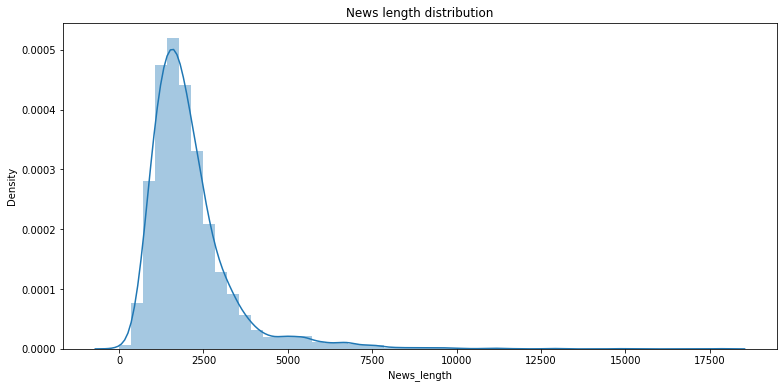

In [40]:
plt.figure(figsize=(12.8,6))
sns.distplot(train['News_length']).set_title('News length distribution');

In [41]:
train['News_length'].describe()

count     5151.000000
mean      2107.196273
std       1296.455505
min          1.000000
25%       1338.000000
50%       1812.000000
75%       2462.000000
max      17828.000000
Name: News_length, dtype: float64

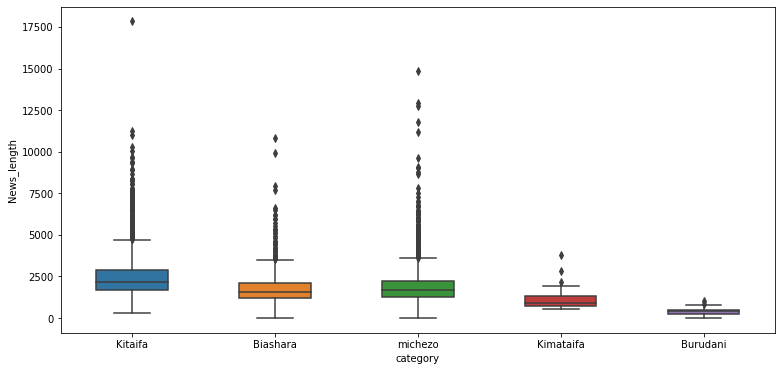

In [42]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=train, x='category', y='News_length', width=.5);

**Feature Engineering**


The next step is to create features from the raw text so we can train the machine learning models. The steps followed are:

1. **Text Cleaning and Preparation:** cleaning of special characters, downcasing, punctuation signs. possessive pronouns and stop words removal and lemmatization.
2. **Label coding:** creation of a dictionary to map each category to a code.
3. **Train-test split:** to test the models on unseen data.
4. **Text representation:** use of TF-IDF scores to represent text.

In [43]:

train['content']= train['content'].apply(lambda x: x.lower())# Lower case
train['content'] = train['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # removing special chars

In [44]:
test['content']= test['content'].apply(lambda x: x.lower())# Lower case
test['content'] = test['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # removing special chars

In [45]:
train.loc[8]['content']

' katika uzinduzi huo rais amesema kuna haja ya kutafuta majawabu kuhusu namna ya kuongeza maghala ya kuhifadhia mazao kwani kadiri kilimo kinavyoboreshwa mazao yanayozalishwa yanakosa pa kuhifadhiwarais kikwete aliyasema hayo dar es salaam juzi wakati akizindua kampuni hiyo ambayo itakuwa chini ya mamlaka ya soko la bidhaa tanzania cmsa alisema uzinduzi wa soko hilo ambalo litaanza kufanya kazi rasmi mwezi mei mwakani kwa kuanzia na mazao ya korosho ufuta alizeti na mpunga ni muendelezo wa jitihada za serikali katika kuleta mageuzi ya kilimo nchinihii ni habari njema kwa wakulima wa tanzania kwani katika jitihada zetu za kuleta mageuzi ya kilimo zisingefanikiwa kama tanzania kusingekuwa na soko la uhakika mfumo uliopo sasa unawakandamiza wakulima na kuwanufaisha walanguzi alisema rais kikwetealisema pamoja na kuanzishwa kwa sera ya kilimo kwanza stakabadhi ghalani uanzishwaji wa benki ya wakulima na vyama vya ushirika kwa ajili ya kuboresha sekta ya kilimo nchini bado sekta hiyo ilika

**3 Text representation**

We have various options:

- Count Vectors as features
- TF-IDF Vectors as features
- Word Embeddings as features
- Text / NLP based features
- Topic Models as feature

We'll use TF-IDF Vectors as features.

In [46]:
# FUNCTIONS
def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, metrics_report, (precision, recall, fscore) 


#export
def load_data(file_path):
    """ Load the csv file and return a Dataframe. """
    df = pd.read_csv(file_path, delimiter=',')
    return df



def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    return label_encoder

In [47]:
# Create tfidf features from the text
ngram_range   = (1, 1)
max_features  = None
vectorizer = TfidfVectorizer(input='content', ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)

X = vectorizer.fit_transform(train['content'].values)

# Encode the labels
labels = train.category.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(train.category)

**2. Train - test split**
- We'll set apart a test set to prove the quality of our models. We'll do Cross Validation in the train set in order to tune the hyperparameters and then test performance on the unseen data of the test set.

In [48]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))


Training set Shape: (4120, 22374)  | Test set Shape: (1031, 22374)


**MODEL TRAINING**

Once we have our feature vectors built, we'll try several machine learning classification models in order to find which one performs best on our data. We will try with the following models:

- SVM
- Random Forest
- Support Vector Machine
- K Nearest Neighbors
- Multinomial Naïve Bayes
- Multinomial Logistic Regression
- Gradient Boosting

**1. SVM**

Number of documents = 4120  |  Number of features = 22374
Start training...done!
Start testing...done!
Total time: 0.26s
accuracy: 0.8642095053346266
              precision    recall  f1-score   support

     Kitaifa       0.79      0.88      0.83       272
    Biashara       1.00      0.25      0.40         4
     michezo       0.29      0.18      0.22        11
   Kimataifa       0.86      0.81      0.84       400
    Burudani       0.94      0.94      0.94       344

    accuracy                           0.86      1031
   macro avg       0.78      0.61      0.65      1031
weighted avg       0.86      0.86      0.86      1031



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


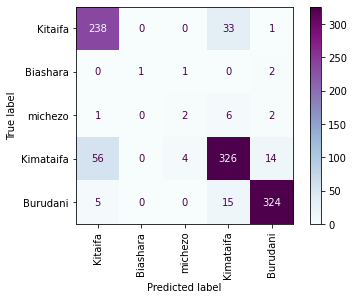

In [49]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

**2.RANDOM FOREST**

Number of documents = 4120  |  Number of features = 22374
Start training...done!
Start testing...

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

done!
Total time: 3.11s
accuracy: 0.8428709990300679
              precision    recall  f1-score   support

     Kitaifa       0.85      0.72      0.78       272
    Biashara       0.00      0.00      0.00         4
     michezo       0.00      0.00      0.00        11
   Kimataifa       0.77      0.89      0.82       400
    Burudani       0.94      0.92      0.93       344

    accuracy                           0.84      1031
   macro avg       0.51      0.51      0.51      1031
weighted avg       0.84      0.84      0.84      1031



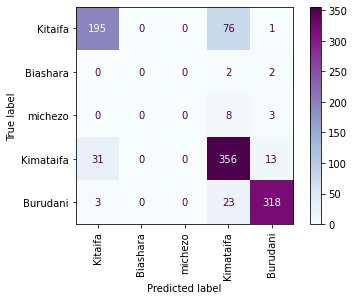

In [50]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

**3.MultinomialNB**

Number of documents = 4120  |  Number of features = 22374
Start training...done!
Start testing...done!
Total time: 0.03s
accuracy: 0.7885548011639185
              precision    recall  f1-score   support

     Kitaifa       0.89      0.52      0.66       272
    Biashara       0.00      0.00      0.00         4
     michezo       0.00      0.00      0.00        11
   Kimataifa       0.67      0.93      0.78       400
    Burudani       0.94      0.88      0.91       344

    accuracy                           0.79      1031
   macro avg       0.50      0.46      0.47      1031
weighted avg       0.81      0.79      0.78      1031



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

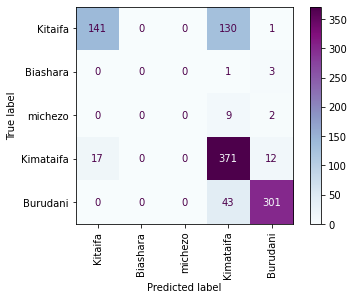

In [51]:
nb_model = MultinomialNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")


**4.Multinomial Logistic Regression**

Number of documents = 4120  |  Number of features = 22374
Start training...done!
Start testing...done!
Total time: 3.69s
accuracy: 0.8758486905916586
              precision    recall  f1-score   support

     Kitaifa       0.85      0.85      0.85       272
    Biashara       0.00      0.00      0.00         4
     michezo       0.00      0.00      0.00        11
   Kimataifa       0.84      0.87      0.85       400
    Burudani       0.94      0.94      0.94       344

    accuracy                           0.88      1031
   macro avg       0.53      0.53      0.53      1031
weighted avg       0.86      0.88      0.87      1031



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

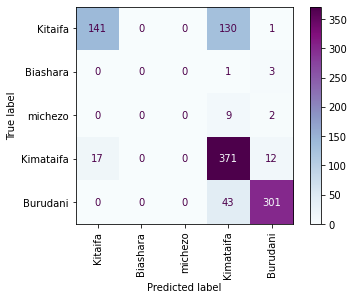

In [52]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(lr_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

**5.K Nearest Neighbors**

Number of documents = 4120  |  Number of features = 22374
Start training...done!
Start testing...done!
Total time: 1.00s
accuracy: 0.7982541222114452
              precision    recall  f1-score   support

     Kitaifa       0.67      0.82      0.74       272
    Biashara       0.50      0.25      0.33         4
     michezo       0.00      0.00      0.00        11
   Kimataifa       0.81      0.70      0.75       400
    Burudani       0.91      0.92      0.91       344

    accuracy                           0.80      1031
   macro avg       0.58      0.54      0.55      1031
weighted avg       0.80      0.80      0.79      1031



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

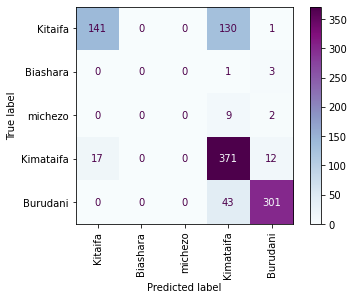

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(knn_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

**6.Gradient Boosting Machine**


Number of documents = 4120  |  Number of features = 22374
Start training...done!
Start testing...done!
Total time: 106.02s
accuracy: 0.8486905916585838
              precision    recall  f1-score   support

     Kitaifa       0.85      0.77      0.81       272
    Biashara       0.00      0.00      0.00         4
     michezo       0.10      0.09      0.10        11
   Kimataifa       0.80      0.86      0.83       400
    Burudani       0.94      0.93      0.94       344

    accuracy                           0.85      1031
   macro avg       0.54      0.53      0.53      1031
weighted avg       0.85      0.85      0.85      1031



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


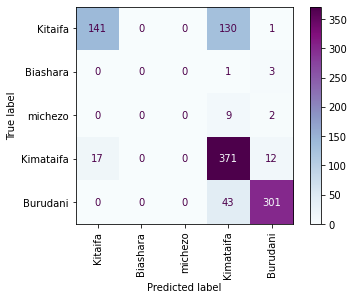

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(gb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

**Cross Validation of the model**
- To DEAL with imbalanced datasets, cross validation will be performed.

In [55]:
#List of all the models
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    LogisticRegression()
]
#Choose the number of cross validations
CV = 5
#dataframe
cv_df = pd.DataFrame(index=range(CV * len(models)))
#iterate over the models, fit the models and store their accuracies in a list entries
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

#convert the list to datframe
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [56]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.642095
1,RandomForestClassifier,1,0.657282
2,RandomForestClassifier,2,0.640777
3,RandomForestClassifier,3,0.643689
4,RandomForestClassifier,4,0.669903
5,LinearSVC,0,0.861300
6,LinearSVC,1,0.869903
7,LinearSVC,2,0.857282
8,LinearSVC,3,0.862136
9,LinearSVC,4,0.871845


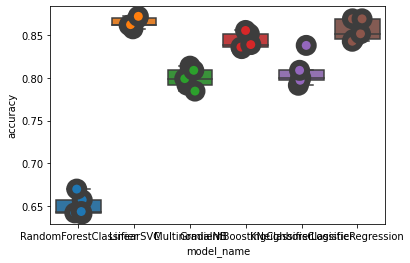

In [57]:
#plot the model accuracies
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=15, jitter=True, edgecolor="gray", linewidth=6)
plt.show()

In [58]:
#group the mean accuracy of the model by the names of the model
cv_df.groupby('model_name').accuracy.mean()

model_name
GradientBoostingClassifier    0.843139
KNeighborsClassifier          0.807029
LinearSVC                     0.864493
LogisticRegression            0.855370
MultinomialNB                 0.799458
RandomForestClassifier        0.650749
Name: accuracy, dtype: float64

- SVC, logistic regression and Gradient Boosting have the highest accuracies

In [59]:
# Using SVC 
y_pred = svm.predict( X_test)
y_pred

array([4, 3, 4, ..., 4, 4, 4])

In [70]:
model = svm

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, train.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

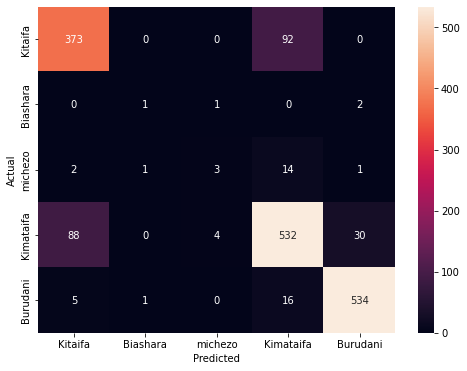

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(confusion_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

- Testing the predictions

In [62]:
from IPython.display import display

for predicted in category_id_df.category_code:
  for actual in category_id_df.category_code:
    if predicted != actual and confusion_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], confusion_mat[actual, predicted]))
      display(train.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['category', 'content']])
      print('')

'Kimataifa' predicted as 'Kitaifa' : 88 examples.


,category,content
4345,Kitaifa,benki ya maendeleo ya afrika afdb inatarajia ...
265,Kitaifa,vanila ni zao linalojulikana zaidi mkoani kag...
2651,Kitaifa,kampuni ya lafargeholcim tanzania inayotengen...
4834,Kitaifa,tanzania na uganda zimeeleza kuwa mipango ya ...
4315,Kitaifa,waziri wa maliasili na utalii dk hamisi kigwa...
...,...,...
4149,Kitaifa,tanzania imeweka rekodi yake ya kuwa na akiba...
4479,Kitaifa,katika msimu wa kuelekea krismasi na mwaka mp...
4388,Kitaifa,imebainika kuwa asilimia kubwa ya kofi a ngum...
3119,Kitaifa,matunda ya uwekezaji mkubwa katika kiwanda ch...



'Kitaifa' predicted as 'Kimataifa' : 92 examples.


,category,content
862,Biashara,waziri wa ujenzi uchukuzi na mawasiliano isac...
866,Biashara,mauzo ya bima ya uingizaji mizigo nchini yame...
1793,Biashara,serikali imefanya uwekezaji wa sh trilioni 54...
2160,Biashara,wakiwasilisha utafiti uliofanywa nchini tanza...
4816,Biashara,kenya sasa inaweza kuuza maparachichi nchini ...
...,...,...
3820,Biashara,katibu mkuu ofisi ya waziri mkuu tawala za mi...
768,Biashara,akisoma hotuba kwa niaba ya mama pinda naibu ...
4557,Biashara,mpango huo uliopewa jina la kili challenge un...
4368,Biashara,waziri wa nchi ofisi ya rais uhusiano na urat...



'michezo' predicted as 'Kimataifa' : 14 examples.


,category,content
39,Kimataifa,serikali ya kenya imetangaza kuongeza mishaha...
3528,Kimataifa,kiongozi wa kanisa katoliki duniani papa fran...
1593,Kimataifa,mahakama nchini afrika kusini imetoa hati ya k...
302,Kimataifa,mwili wa rais wa zamani wa zimbabwe robert mu...
3917,Kimataifa,wanafunzi katika chuo kikuu cha cape town afr...
575,Kimataifa,serikali imetoa tahadhari kwa shule 108 za ms...
2510,Kimataifa,rais salva kiir amesema yuko tayari kukutana ...
3194,Kimataifa,serikali ya gabon imefanikiwa kuzima jaribio ...
872,Kimataifa,sakata la binti wa uingereza shamima begum an...
2027,Kimataifa,baadhi ya nchi barani afrika zikiwemo rwanda ...



'Burudani' predicted as 'Kimataifa' : 16 examples.


,category,content
1771,michezo,kauli ya diamond imekuja juzi baada ya kumali...
2509,michezo,katibu mkuu kiongozi ambaye pia ni mkuu wa ut...
4299,michezo,hatua hiyo imekuja baada ya mshitakiwa masoga...
2272,michezo,mahakama ya hakimu mkazi kisutu dar es salaam...
2318,michezo,waziri mkuu kassim majaliwa ameagiza halmasha...
464,michezo,mkuu wa mkoa wa morogoro loata ole sanare ame...
565,michezo,lulu aliye nje kwa dhamana atapanda kizimbani...
737,michezo,waziri wa nishati dk medard kalemani amewatak...
3362,michezo,alisema uchunguzi wa sampuli ya mkojo wa wema...
3633,michezo,agizo lilitolewa na rais john magufuli akiwa ...



'Kimataifa' predicted as 'Burudani' : 30 examples.


,category,content
1960,Kitaifa,klabu ya azam fc imewatema nyota wanane kweny...
1299,Kitaifa,msanii wa muziki nchini richard mavoko amekan...
1687,Kitaifa,kocha mkuu wa simba patrick aussems amesema n...
1115,Kitaifa,simba jana ilifungwa mabao 54 na sevilla ya h...
4079,Kitaifa,wawakilishi wa tanzania katika michuano ya kl...
2036,Kitaifa,mwezi uliopita mbunge wa geita vijijini josep...
2102,Kitaifa,mahakama ya hakimu mkazi kisutu imeshindwa ku...
2620,Kitaifa,simba jana iliendelea vema na kampeni za kute...
728,Kitaifa,mwanariadha joshua cheptegei amekuwa mganda w...
1852,Kitaifa,zaidi ya shilingi milioni 300 zinatarajiwa ku...


In [63]:
# Examples
#Store 10 news items in a list
texts = ["Shirika la kutetea haki za binadamu Amnesty International tawi la Kenya limetoa wito kwa serikali ya Kenya kutowalazimisha raia wake kupewa chanjo ya Covod -19.",
         "Maafisa wa polisi jijini Nairobi wameanzisha uchunguzi baada ya mfanyakazi wa BBC kupatikana amefariki jijini humo.",
         "Aliye kuwa rais wa Marekani atembelea taifa la  Kenya",
         "Uchanguzi  yafanyika nchini Kenya mnamo mwakani",
         'Rais wa Tanzania azuru Kenya.'
         ]
#transform the test data
text_features = vectorizer.transform(texts)
#Predict the transformed test data
predictions = model.predict(text_features)
#iterate over the test data and their predictions and print them with their predicted class
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Shirika la kutetea haki za binadamu Amnesty International tawi la Kenya limetoa wito kwa serikali ya Kenya kutowalazimisha raia wake kupewa chanjo ya Covod -19."
  - Predicted as: 'Kimataifa'

"Maafisa wa polisi jijini Nairobi wameanzisha uchunguzi baada ya mfanyakazi wa BBC kupatikana amefariki jijini humo."
  - Predicted as: 'michezo'

"Aliye kuwa rais wa Marekani atembelea taifa la  Kenya"
  - Predicted as: 'michezo'

"Uchanguzi  yafanyika nchini Kenya mnamo mwakani"
  - Predicted as: 'Biashara'

"Rais wa Tanzania azuru Kenya."
  - Predicted as: 'Kimataifa'



In [66]:
test.columns

Index(['swahili_id', 'content'], dtype='object')

**Save the best model**

In [64]:
model =model

In [65]:
#dumb the LinearSVC model in a pickle file
joblib.dump(model, 'Swahili_model.pkl')

['Swahili_model.pkl']

In [ ]:
#read  the model
Swahili_model = open('Swahili_model.pkl','rb')

In [ ]:
#load the model
model = joblib.load(Swahili_model)

In [ ]:
#Check model parameters
model

LinearSVC(C=0.1, class_weight='balanced', max_iter=10000, verbose=False)

- Save the Vectorizer

In [ ]:
import pickle
pickle.dump(vectorizer, open("vector.pickel", "wb"))

In [ ]:
vectorizer = pickle.load(open("vector.pickel", "rb"))